## This tutorial is originally published by William Koehrsen at
https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [150]:
# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd
# os for getting API key
import os

In [151]:
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Retrieve Data from Quandl

You need to replace the api_key with your own api_key.

In [152]:
# Get the API key from local environment variable
quandl.ApiConfig.api_key = os.environ.get('QUANDL_KEY')

# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')

# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


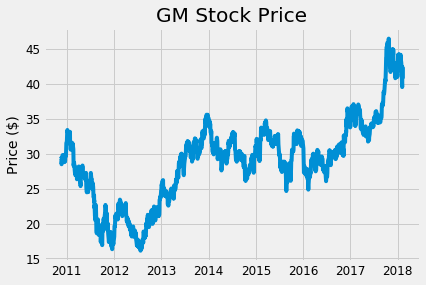

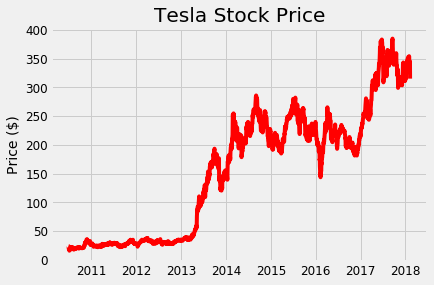

In [153]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

In [154]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 
                2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}

gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 
                2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010: 1.50e9}

### Calculate Market Capitalization

In [155]:
# Create a year column 
tesla['Year'] = tesla.index.year

# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    
    # Update the cap column to shares times the price
    tesla.loc[i, 'cap'] = shares * tesla.loc[i, 'Adj. Close']

In [156]:
# Create a year column 
gm['Year'] = gm.index.year

# Take Dates from index and move to Date column 
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0

# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    
    # Update the cap column to shares times the price
    gm.loc[i, 'cap'] = shares * gm.loc[i, 'Adj. Close']

In [157]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')
cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)

In [158]:
# Select only the relevant columns
cars = cars.loc[:, ['Date', 'gm_cap', 'tesla_cap']]

# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9

cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


### Visual Comparison

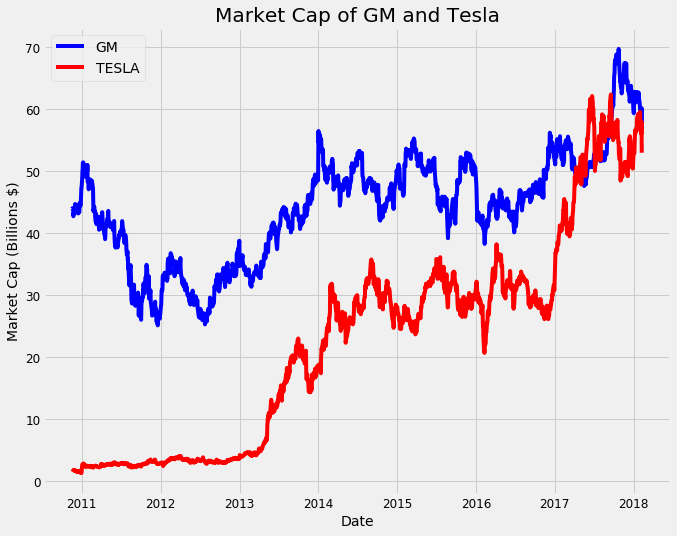

In [159]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'b-', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

Tesla briefly surpassed GM in market cap in 2017. When did this occur?

In [160]:
import numpy as np

# Find the first and last time Tesla was valued higher than GM
first_date = cars.loc[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.loc[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']

print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2017-09-21.


# Prophet Models

In [161]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9

# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
gm_prophet.fit(gm)

# Repeat for the tesla data
tesla =tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
tesla['y'] = tesla['y'] / 1e9
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, n_changepoints=10)
tesla_prophet.fit(tesla);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harrywang/Documents/sandbox/data-analysis-tutorials/time-series/venv/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Predictions for 2 Years

In [162]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

tesla_forecast = tesla_prophet.make_future_dataframe(periods=365*2, freq='D')
tesla_forecast = tesla_prophet.predict(tesla_forecast)

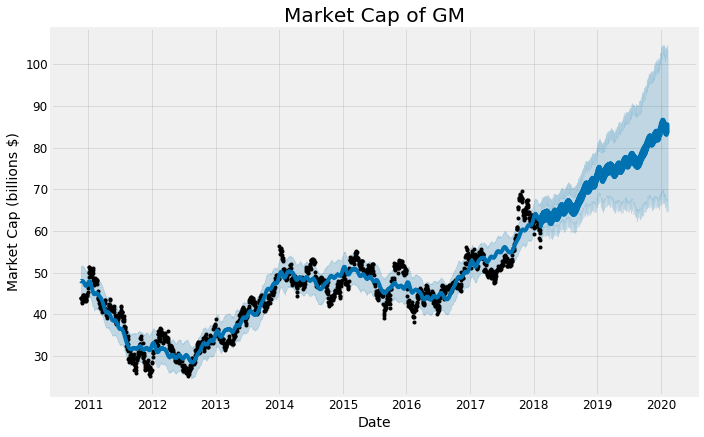

In [163]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM');

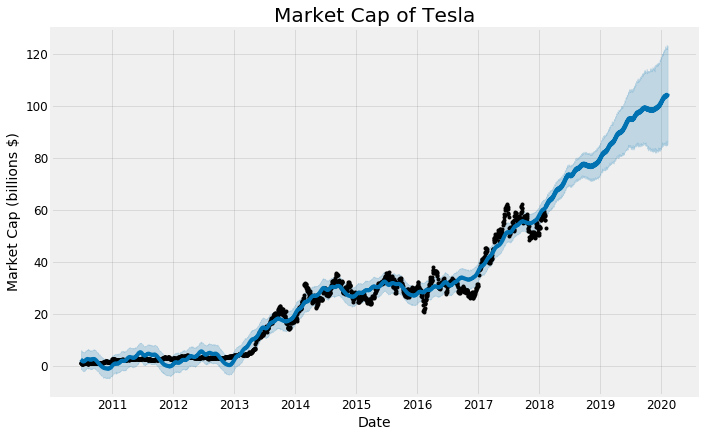

In [164]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla');

## Effect of Changepoint Prior Scale

In [165]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(tesla)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    tesla[changepoint] = future['yhat']

/Users/harrywang/Documents/sandbox/data-analysis-tutorials/time-series/venv/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


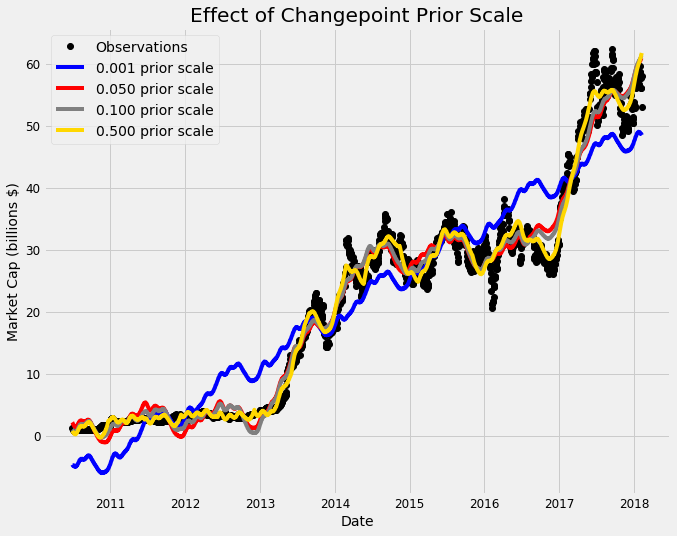

In [166]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(tesla['ds'], tesla['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(tesla['ds'], tesla[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)'); plt.title('Effect of Changepoint Prior Scale');

In [167]:
gm_prophet.changepoints[:10]

58    2011-02-11
116   2011-05-06
174   2011-07-29
232   2011-10-20
291   2012-01-17
349   2012-04-10
407   2012-07-02
465   2012-09-24
523   2012-12-18
581   2013-03-14
Name: ds, dtype: datetime64[ns]

In [168]:
tesla_prophet.changepoints[:10]

153    2011-02-04
307    2011-09-15
460    2012-04-25
613    2012-12-04
766    2013-07-16
920    2014-02-25
1073   2014-10-02
1226   2015-05-13
1380   2015-12-21
1533   2016-08-01
Name: ds, dtype: datetime64[ns]

# Compare Forecasts
We want to determine when Tesla will overtake GM in total market value. We already have the forecasts for two years into the future. We will now join them together and determine when the model predicts Tesla will pull ahead. 

In [169]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]

# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()

# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names

In [170]:
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')

# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)
forecast.head()

,Date,gm_trend,gm_trend_lower,gm_trend_upper,gm_yhat_lower,gm_yhat_upper,gm_seasonal,gm_seasonal_lower,gm_seasonal_upper,gm_seasonalities,...,tesla_seasonalities,tesla_seasonalities_lower,tesla_seasonalities_upper,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_yhat
0,2010-11-18,46.926619,46.926619,46.926619,44.626786,51.516075,1.039729,1.039729,1.039729,1.039729,...,-2.715513,-2.715513,-2.715513,-0.203622,-0.203622,-0.203622,-2.511891,-2.511891,-2.511891,-0.856269
1,2010-11-19,46.887139,46.887139,46.887139,44.173078,51.514138,1.041488,1.041488,1.041488,1.041488,...,-2.744898,-2.744898,-2.744898,-0.206908,-0.206908,-0.206908,-2.537990,-2.537990,-2.537990,-0.875313
2,2010-11-22,46.768699,46.768699,46.768699,44.217950,51.645299,1.210915,1.210915,1.210915,1.210915,...,-2.739141,-2.739141,-2.739141,-0.132452,-0.132452,-0.132452,-2.606689,-2.606689,-2.606689,-0.838533
3,2010-11-23,46.729219,46.729219,46.729219,44.180878,51.516068,1.234682,1.234682,1.234682,1.234682,...,-2.773779,-2.773779,-2.773779,-0.146691,-0.146691,-0.146691,-2.627087,-2.627087,-2.627087,-0.862829
4,2010-11-24,46.689738,46.689738,46.689738,44.570985,51.846804,1.335315,1.335315,1.335315,1.335315,...,-2.783054,-2.783054,-2.783054,-0.136473,-0.136473,-0.136473,-2.646581,-2.646581,-2.646581,-0.861764


### Visualize Trend Only and the Forecast

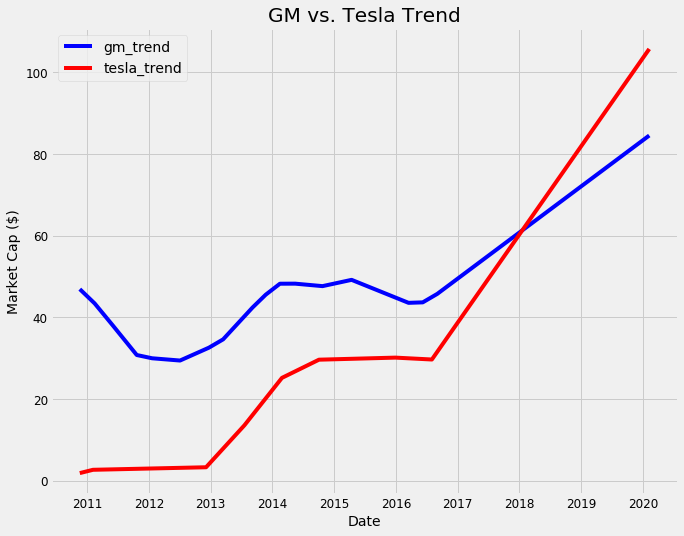

In [171]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('GM vs. Tesla Trend'); 

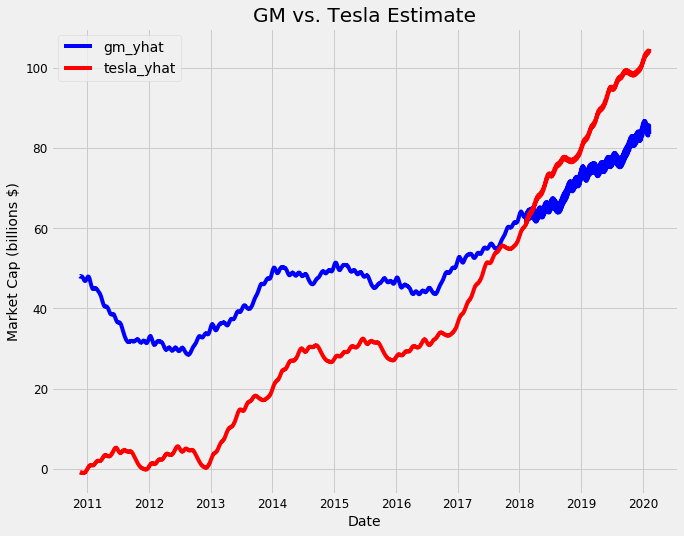

In [172]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['tesla_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap (billions $)')
plt.title('GM vs. Tesla Estimate'); 

In [173]:
overtake_date = min(forecast.loc[forecast['tesla_yhat'] > forecast['gm_yhat'], 'Date'])
print('Tesla overtakes GM on {}'.format(overtake_date))

Tesla overtakes GM on 2018-02-10 00:00:00


## Trends and Patterns

Now, we can use the Prophet Models to inspect different trends in the data. 

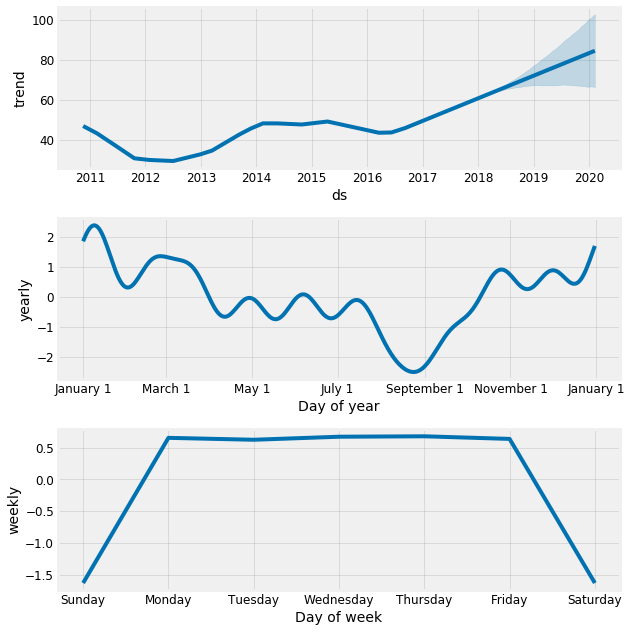

In [174]:
gm_prophet.plot_components(gm_forecast);

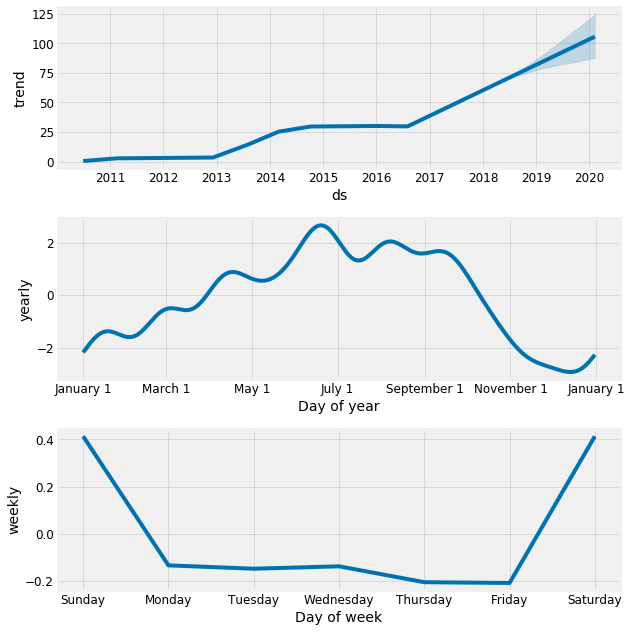

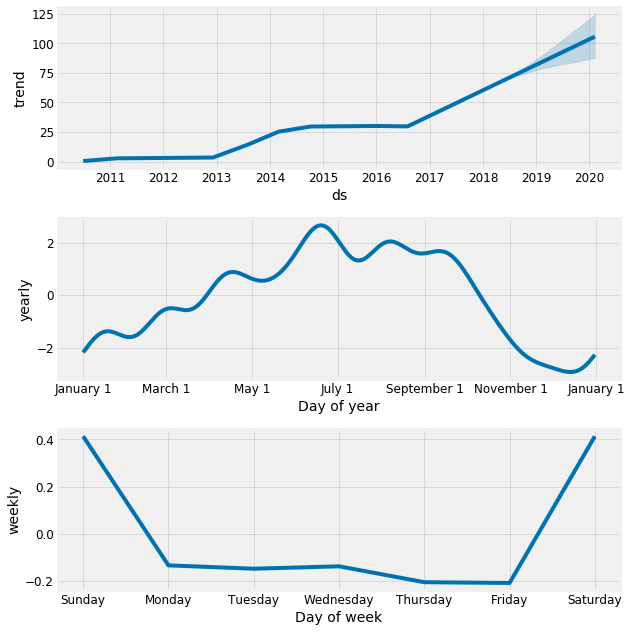

In [175]:
tesla_prophet.plot_components(tesla_forecast)

These graphs show that Tesla tends to increase during the summer, and decrease during the winter, while GM plummets during the summer and increases during the winter. We could compare GM sales with these graphs to see if there is any correlation.

In [176]:
# Read in the sales data
gm_sales = pd.read_csv('data/gm_sales.csv')
gm_sales.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,2017,195909,237388,256224,244406,237364,243151,226107,275552,279397,252813,245387,308539,3002237
1,2016,203745,227825,252128,259557,240449,255209,267258,256429,249795,258626,252644,319108,3042773
2,2015,202786,231378,249875,269055,293097,259346,272512,270480,251310,262993,229296,290230,3082358
3,2014,171486,222104,256047,254076,284694,267461,256160,272422,223437,226819,225818,274483,2935007
4,2013,194699,224314,245950,237646,252894,264843,234071,275847,187195,226402,212060,230157,2786078


In [177]:
# Melt the sales data and rename columns
gm_sales = gm_sales.melt(id_vars='Year', var_name = 'Month', value_name = 'Sales')
gm_sales.head(8)

,Year,Month,Sales
0,2017,Jan,195909
1,2016,Jan,203745
2,2015,Jan,202786
3,2014,Jan,171486
4,2013,Jan,194699
5,2012,Jan,167962
6,2011,Jan,178896
7,2010,Jan,145098


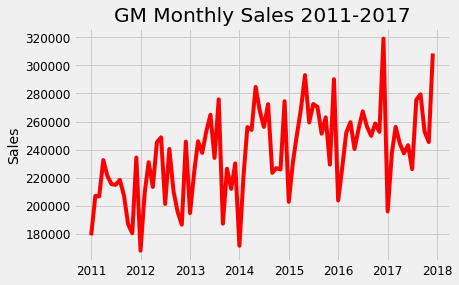

In [178]:
# Format the data for plotting
gm_sales = gm_sales[gm_sales['Month'] != 'Total']
gm_sales = gm_sales[gm_sales['Year'] > 2010]
gm_sales['Date'] = ['-'.join([str(year), month]) for year, month in zip(gm_sales['Year'], gm_sales['Month'])]
gm_sales['Date'] = pd.to_datetime(gm_sales['Date'], format = "%Y-%b")
gm_sales.sort_values(by = 'Date', inplace=True)
gm_sales['Month'] = [date.month for date in gm_sales['Date']]

# Plot the sales over the period
plt.plot(gm_sales['Date'], gm_sales['Sales'], 'r');
plt.title('GM Monthly Sales 2011-2017'); plt.ylabel('Sales');

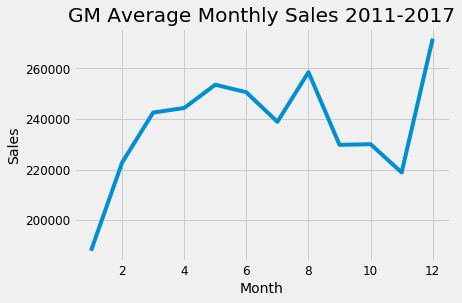

In [179]:
gm_sales_grouped = gm_sales.groupby('Month').mean()
plt.plot(list(range(1, 13)), gm_sales_grouped['Sales']);
plt.xlabel('Month'); plt.ylabel('Sales'); plt.title('GM Average Monthly Sales 2011-2017');

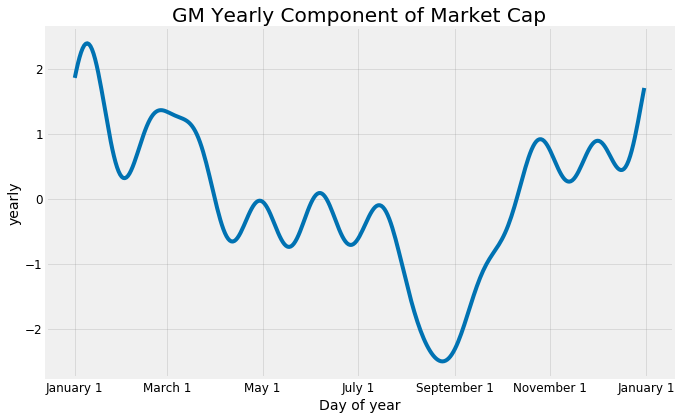

In [180]:
gm_prophet.plot_yearly(); plt.title('GM Yearly Component of Market Cap');

It does not appear as if there is much correlation between market capitalization (a proxy for share price) and sales over the course of a year.

# US vs. China Gross Domestic Product

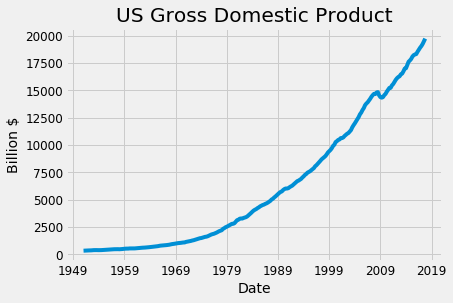

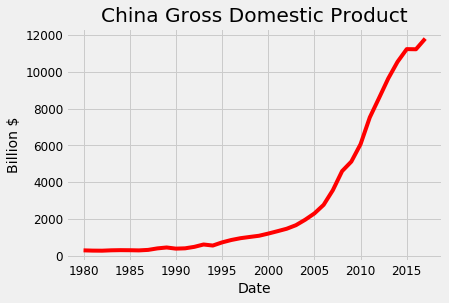

In [181]:
# My personal api key, use your own
quandl.ApiConfig.api_key = os.environ.get('QUANDL_KEY')

# Get data from quandl for US and China GDP
us_gdp = quandl.get('FRED/GDP', collapse='quarterly', start_date = '1950-12-31', end_date='2017-12-31')
china_gdp = quandl.get('ODA/CHN_NGDPD', collapse='yearly', start_date = '1950-12-31', end_date='2017-12-31')

us_gdp.plot(title = 'US Gross Domestic Product', legend=None);
plt.ylabel('Billion $'); 
china_gdp.plot(title = 'China Gross Domestic Product', color = 'r', legend=None);
plt.ylabel('Billion $');

In [182]:
# Change index to date column
us_gdp = us_gdp.reset_index(level=0)
us_gdp.head(5)

,Date,Value
0,1951-03-31,336.372
1,1951-06-30,344.455
2,1951-09-30,351.774
3,1951-12-31,356.579
4,1952-03-31,360.195


In [183]:
china_gdp = china_gdp.reset_index(level=0)
china_gdp.head(5)

,Date,Value
0,1980-12-31,305.350
1,1981-12-31,290.724
2,1982-12-31,286.729
3,1983-12-31,307.683
4,1984-12-31,316.666


In [184]:
# Merge the two gdp data frames and rename columns
gdp = us_gdp.merge(china_gdp, on = 'Date', how = 'left').rename(columns={'Value_x': 'US', 'Value_y': 'China'})
gdp.head(5)

,Date,US,China
0,1951-03-31,336.372,NaN
1,1951-06-30,344.455,NaN
2,1951-09-30,351.774,NaN
3,1951-12-31,356.579,NaN
4,1952-03-31,360.195,NaN


In [185]:
round(gdp.describe(), 2)

,US,China
count,268.00,38.00
mean,6109.79,2977.56
std,5860.21,3738.06
min,336.37,286.73
25%,879.05,412.84
50%,4051.19,1064.85
75%,10540.69,4346.08
max,19738.89,11795.30


In [186]:
# Fill in missing China observations using backward fill
gdp = gdp.fillna(method='bfill')

## Visualize the data

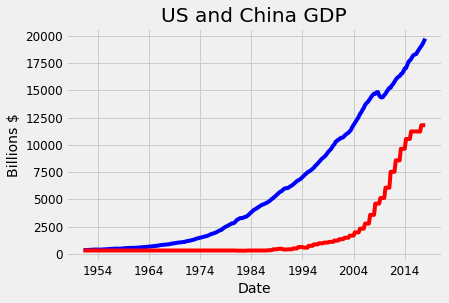

In [187]:
plt.plot(gdp['Date'], gdp['US'], label = 'US', color =  'b')
plt.plot(gdp['Date'], gdp['China'], label = 'China', color = 'r')
plt.ylabel('Billions $'); plt.title('US and China GDP'); plt.xlabel('Date');

## Make Predictions of Future GDP

In [188]:
# Create a prophet object for each dataframe
us_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)
china_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Prophet needs dataframes with a ds (date) and y (variable) column
# Use pandas rename functionality (format is dictionary with {'old': 'new'})
us_gdp = us_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})
china_gdp = china_gdp.rename(columns={'Date': 'ds', 'Value': 'y'})

In [189]:
us_prophet.fit(us_gdp);
china_prophet.fit(china_gdp);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harrywang/Documents/sandbox/data-analysis-tutorials/time-series/venv/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [190]:
us_prophet.changepoints

9     1953-06-30
17    1955-06-30
26    1957-09-30
34    1959-09-30
43    1961-12-31
51    1963-12-31
60    1966-03-31
68    1968-03-31
77    1970-06-30
86    1972-09-30
94    1974-09-30
103   1976-12-31
111   1978-12-31
120   1981-03-31
128   1983-03-31
137   1985-06-30
146   1987-09-30
154   1989-09-30
163   1991-12-31
171   1993-12-31
180   1996-03-31
188   1998-03-31
197   2000-06-30
205   2002-06-30
214   2004-09-30
Name: ds, dtype: datetime64[ns]

### Compare US changepoints to recessions

The prophet object only selects changepoints from the first 80% of the data which is why the recent recession does not appear. We can try and correlate the identified changepoints with actual recessions.

In [191]:
recessions = pd.read_csv('data/recessions.csv', encoding='latin')

In [192]:
recessions[6:]

,name,time,duration,max_unemp,gdp_decline,desc
6,Recession of 1960Ð61,Apr 1960ÊÐ Feb 1961,10 months,0.071,_1.6%,Another primarily monetary recession occurred ...
7,Recession of 1969Ð70,Dec 1969ÊÐNov 1970,11 months,0.061,_0.6%,The relatively mild 1969 recession followed a ...
8,1973Ð75 recession,Nov 1973ÊÐ Mar 1975,1 year 4 months,0.09,_3.2%,"TheÊ1973 oil crisis, a quadrupling of oil pric..."
9,1980 recession,JanÐJuly 1980,6 months,0.078,_2.2%,The NBER considers a very short recession to h...
10,1981Ð1982 recession,July 1981ÊÐ Nov 1982,1 year 4 months,0.108,_2.7%,TheÊIranian RevolutionÊsharply increased the p...
11,Early 1990s recession,July 1990ÊÐ Mar 1991,8 months,0.078,_1.4%,After the lengthy peacetime expansion of the 1...
12,Early 2000s recession,Mar 2001ÐNov 2001,8 months,0.063,_0.3%,The 1990s were the longest period of growth in...
13,Great Recession,Dec 2007 Ð June 2009,1 year 6 months,0.1,_5.1%,TheÊsubprime mortgage crisisÊled to the collap...


In [193]:
# Make a future dataframe with 50 years of observations 
# US dataframe and predictions
us_forecast = us_prophet.make_future_dataframe(periods = 50, freq = 'Y')
us_forecast = us_prophet.predict(us_forecast)

# China dataframe and predictions
china_forecast = china_prophet.make_future_dataframe(periods = 50, freq = 'Y')
china_forecast = china_prophet.predict(china_forecast)

## Plot Future Predictions

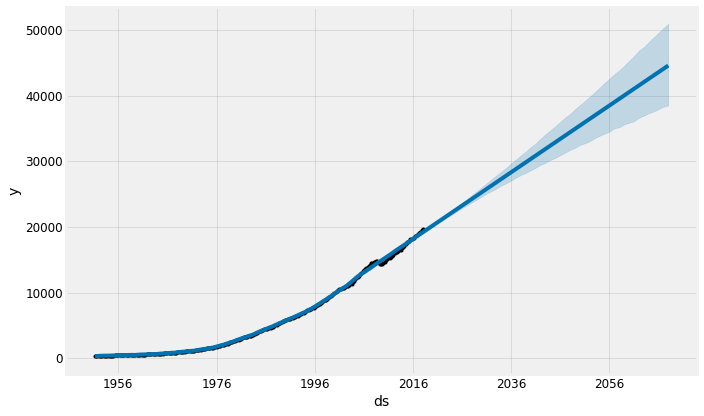

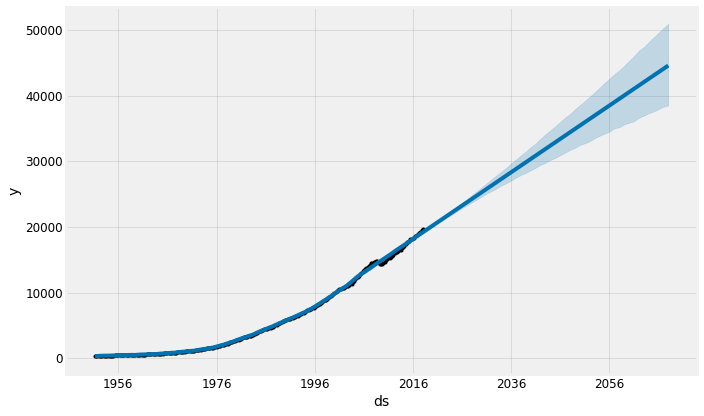

In [194]:
us_prophet.plot(us_forecast)

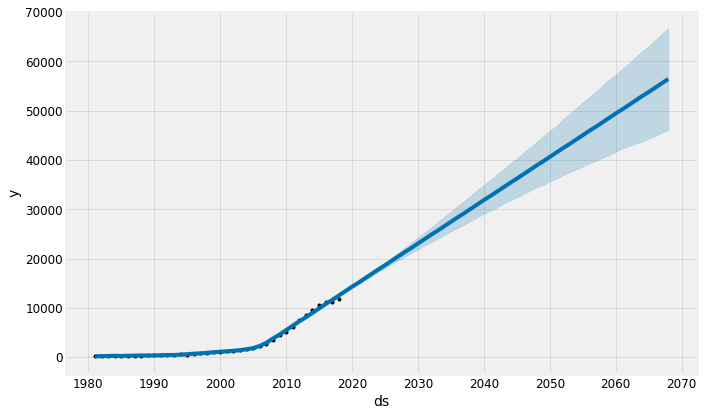

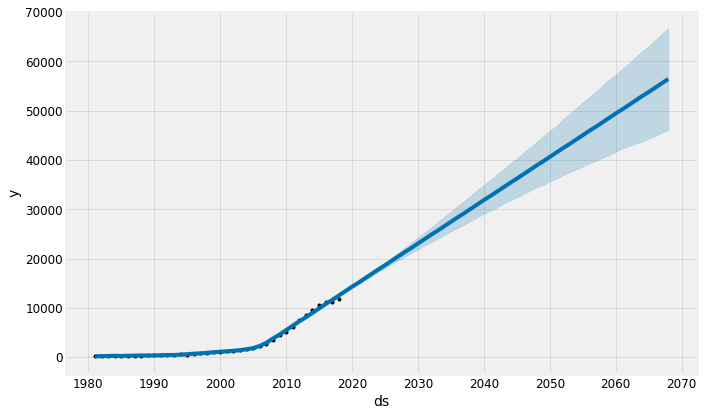

In [195]:
china_prophet.plot(china_forecast)

# When will China Overtake the United States?

In [196]:
us_names = ['us_%s' % column for column in us_forecast.columns]
china_names = ['china_%s' % column for column in china_forecast.columns]

# Dataframes to merge
merge_us_forecast = us_forecast.copy()
merge_china_forecast = china_forecast.copy()

# Rename the columns
merge_us_forecast.columns = us_names
merge_china_forecast.columns = china_names

In [197]:
# Merge the two datasets
gdp_forecast = pd.merge(merge_us_forecast, merge_china_forecast, how = 'inner', left_on = 'us_ds', right_on = 'china_ds')

# Rename date column
gdp_forecast = gdp_forecast.rename(columns={'us_ds': 'Date'}).drop('china_ds', axis=1)
gdp_forecast.head()

,Date,us_trend,us_trend_lower,us_trend_upper,us_yhat_lower,us_yhat_upper,us_seasonal,us_seasonal_lower,us_seasonal_upper,us_seasonalities,...,china_seasonal,china_seasonal_lower,china_seasonal_upper,china_seasonalities,china_seasonalities_lower,china_seasonalities_upper,china_yearly,china_yearly_lower,china_yearly_upper,china_yhat
0,1980-12-31,3535.280251,3535.280251,3535.280251,2747.780963,3191.823227,-552.643633,-552.643633,-552.643633,-552.643633,...,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,221.512620
1,1981-12-31,3795.320212,3795.320212,3795.320212,3031.088937,3470.710578,-553.625269,-553.625269,-553.625269,-553.625269,...,-197.901360,-197.901360,-197.901360,-197.901360,-197.901360,-197.901360,-197.901360,-197.901360,-197.901360,253.208063
2,1982-12-31,4055.360429,4055.360429,4055.360429,3288.094702,3708.261769,-553.827772,-553.827772,-553.827772,-553.827772,...,-183.796881,-183.796881,-183.796881,-183.796881,-183.796881,-183.796881,-183.796881,-183.796881,-183.796881,285.804690
3,1983-12-31,4356.067924,4356.067924,4356.067924,3598.984089,4007.215501,-553.248949,-553.248949,-553.248949,-553.248949,...,-168.808421,-168.808421,-168.808421,-168.808421,-168.808421,-168.808421,-168.808421,-168.808421,-168.808421,319.285302
4,1984-12-31,4670.945031,4670.945031,4670.945031,3897.593410,4359.547860,-552.643633,-552.643633,-552.643633,-552.643633,...,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,-211.104657,295.531882


## Future Plot with Uncertainty

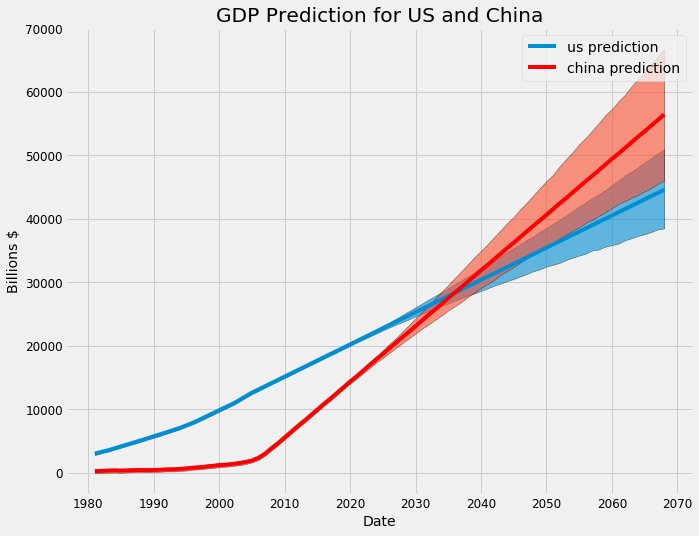

In [198]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8));
ax.plot(gdp_forecast['Date'], gdp_forecast['us_yhat'], label = 'us prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['us_yhat_upper'], gdp_forecast['us_yhat_lower'], alpha=0.6, edgecolor = 'k');
ax.plot(gdp_forecast['Date'], gdp_forecast['china_yhat'], 'r', label = 'china prediction');
ax.fill_between(gdp_forecast['Date'].dt.to_pydatetime(), gdp_forecast['china_yhat_upper'], gdp_forecast['china_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date'); plt.ylabel('Billions $'); plt.title('GDP Prediction for US and China');



In [199]:
first_pass = min(gdp_forecast.loc[gdp_forecast['us_yhat'] < gdp_forecast['china_yhat'], 'Date'])
print('China will overtake the US in GDP on {}.'.format(first_pass))

China will overtake the US in GDP on 2035-12-31 00:00:00.
